Project #5: Video Stitching and Processing 

## CS445: Computational Photography

### Setup


In [47]:
##################################################
# Name: Michael Edukonis
# UIN:677141300
# email:meduk2@illinois.edu
# class:CS445
# assignment:Project 5
# date: 11/25/2023
##################################################
# modify to where you store your project data including utils
datadir = "/home/medukonis/Documents/University of Illinois/Fall_2023/project_5/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
imagesfn = datadir + "images"
!cp -r "$imagesfn" .

cp: '/home/medukonis/Documents/University of Illinois/Fall_2023/project_5/utils.py' and './utils.py' are the same file
cp: '/home/medukonis/Documents/University of Illinois/Fall_2023/project_5/images' and './images' are the same file


In [34]:
#!pip uninstall opencv-python -y
#downgrade OpenCV a bit to use SIFT
#!pip3 install opencv-contrib-python==3.4.2.17 --force-reinstall
#!pip3 install ffmpeg-python # for converting to video

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [3]:
#========================================================================
#Function Name: score_projection(pt1, pt2)
#Input: pt1, pt2 (both are numpy arrays of N points)
#Output: score (count of inliers), inliers (numpy array)
#Function Operation: computes the score corresponding to 
#the number of inliers for RANSAC. Takes two arrays of points, pt1 and 
#pt2, where pt1[:, i] and pt2[:, i] should be close in Euclidean distance 
#if they are inliers. Function calculates the Euclidean distance 
#between each pair of points, determines the inliers (points with a 
#distance less than a set threshold), and counts the number of inliers 
#to give the score. 
#========================================================================

def score_projection(pt1, pt2):
    '''
    Score corresponding to the number of inliers for RANSAC
    Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
    Outputs: score (scalar count of inliers) and inliers (1xN logical array)
    '''
    threshold = 5
    #Calculate Euclidean distance between each pair of points
    distances = np.sqrt(np.sum((pt1 - pt2) ** 2, axis=0))
    
    #Determine inliers (those with a distance less than the threshold)
    inliers = distances < threshold
    
    #Count the number of inliers
    score = np.sum(inliers)

    return score, inliers


#This function was provided
def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    #sift = cv2.xfeatures2d.SIFT_create()
    sift = cv2.SIFT_create()
    
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0
    n_to_sample = 4  #???? # Put the correct number of points here

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)

        
        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        
        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [23]:
#======================================================================================
#Function Name: computeHomography(pts1, pts2, normalization_func=None)
#Input: pts1, pts2 (both are 3xN matrices for N points in homogeneous coordinates),
#        normalization_func (optional function for normalization)
#Output: H (3x3 matrix such that pts2 ~= H*pts1)
#Function Operation: Function computes a homography matrix that maps 
#points from pts1 to pts2 using Singular Value Decomposition (SVD). It 
#constructs a matrix from the point correspondences and computes its SVD. 
#The homography matrix is extracted from the last column of V (or row of 
#V transposed (Vt)). 
#======================================================================================
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    (_, n) = pts1.shape
    A = np.zeros((2 * n, 9))

    for i in range(n):       #loop through the point pairs
        X = pts1[:, i]       #extract corresponding points
        X_prime = pts2[:, i]
        
        #construct the matrix 'A'
        A[2 * i] = [-X[0], -X[1], -1, 0, 0, 0, X_prime[0] * X[0], X_prime[0] * X[1], X_prime[0]]
        A[2 * i + 1] = [0, 0, 0, -X[0], -X[1], -1, X_prime[1] * X[0], X_prime[1] * X[1], X_prime[1]]

    #Compute the SVD of A
    U, S, Vt = np.linalg.svd(A)
    #Take the last column of V or row of V transposed (Vt)
    H = Vt[-1].reshape(3, 3)
    #Normalize so that the last element is 1
    H /= H[-1, -1]
    #If points were normalized, denormalize the homography matrix
    if normalization_func is not None:
        H = np.dot(np.dot(np.linalg.inv(T2), H), T1)

    return H

best score: 221.000000
[[ 1.00000000e+00  3.89562079e-02 -2.06154720e+02]
 [ 1.37365538e-02  9.40198449e-01 -1.61172535e+01]
 [ 3.66651963e-04  1.01213511e-04  7.94096448e-01]]


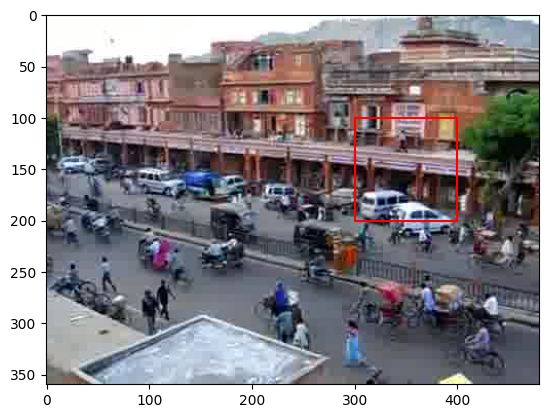

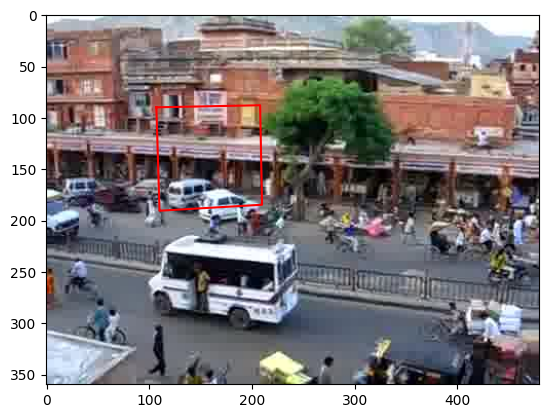

In [55]:

# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

H = auto_homography(im1,im2, computeHomography)
#Print Homography matrix
print(H/H.max()) 

# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
plt.figure()
plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')

#TO DO: project points into im2 and display the projected lines on im2
#Project the box points into the second image using the homography matrix
box_pts_transformed = np.dot(H, box_pts)
# Normalize the points so that the last row is 1
box_pts_transformed = box_pts_transformed / box_pts_transformed[2, :]

#Display im2
plt.figure()
plt.imshow(im2[:, :, [2, 1, 0]])

#Display the projected box on im2
plt.plot(box_pts_transformed[0, :], box_pts_transformed[1, :], 'r-')
plt.show()


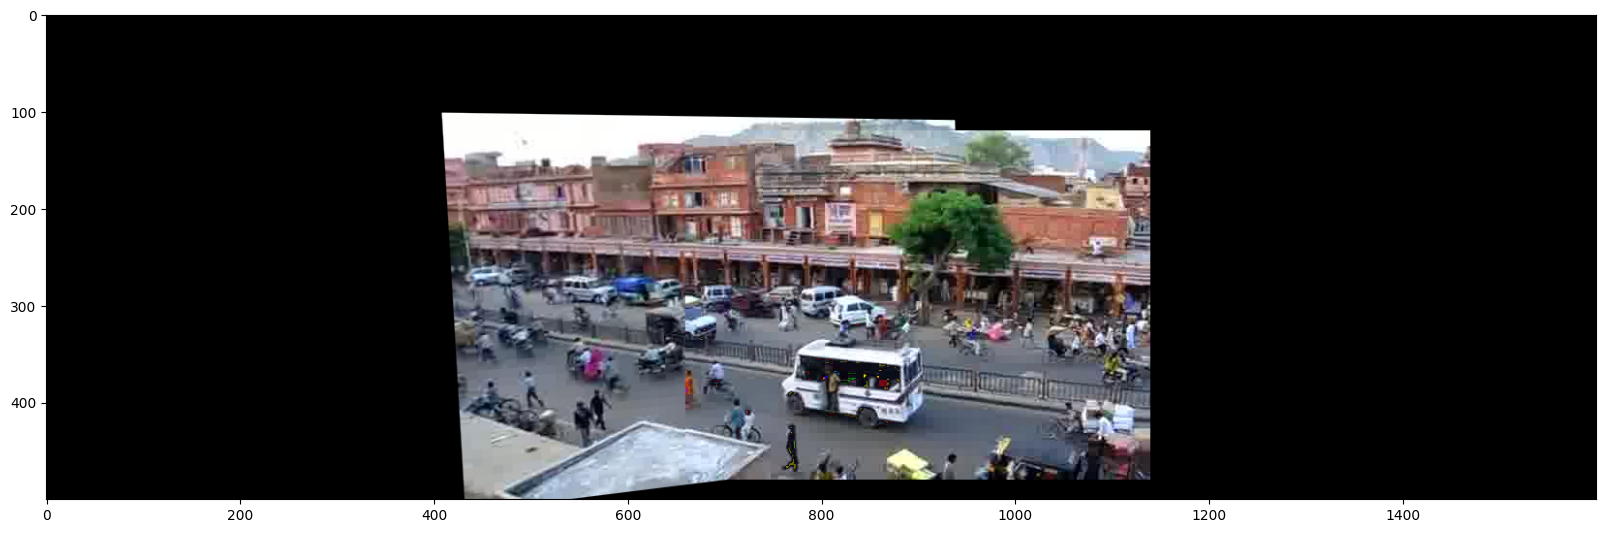

True

In [46]:
projectedWidth = 1600  #provided
projectedHeight = 500   #provided
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]]) #provided

#Homography is computed above - pass to warpPerspective to align
img_warped = cv2.warpPerspective(im1, Tr.dot(H), (projectedWidth, projectedHeight))

#Initialize the reference image space - will be passed in to blendImages
referenceTransform = np.zeros((projectedHeight, projectedWidth, 3), dtype=np.uint8)

# Place the reference image (im2) onto the referenceTransform at the appropriate offset
referenceTransform[120:120+im2.shape[0], 660:660+im2.shape[1]] = im2

# Call the blendImages function to combine the warped source image and the reference image
blendedOutput = utils.blendImages(img_warped, referenceTransform)

# Show the result
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(blendedOutput, cv2.COLOR_BGR2RGB))
plt.show()

# Save the output
cv2.imwrite('part1.jpg', blendedOutput)

### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


best score: 78.000000
best score: 221.000000
best score: 214.000000
best score: 90.000000


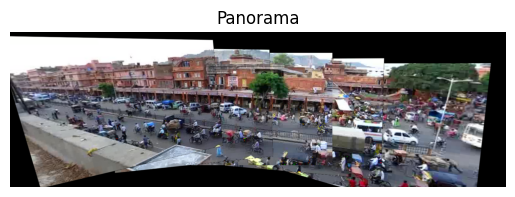

True

In [22]:
#Panorama using five key frames
#key_frames_idx contains indices for the frames we will stitch
key_frames_idx = np.array([90, 270, 450, 630, 810]) - 1
reference_idx = 2  #Index corresponding to the reference frame (450th frame)

#Initialize array to hold each frame
frames = []

#Load the images
for idx in key_frames_idx:
    frame = cv2.imread(f"./images/input/frames/f0{str(idx+1).zfill(3)}.jpg")
    frames.append(frame)

# TO DO solution


#The output size of the panorama
panorama_size = (1600, 500)  # width x height

#Create an empty image for the panorama
panorama = np.zeros((panorama_size[1], panorama_size[0], 3), dtype=np.uint8)

#Initialize list to store homographies
Hs = [None] * len(frames)

#Compute homographies using the auto_homography function
for n, frame in enumerate(frames):
    if n != reference_idx:
        #Compute the homography of the current frame to the reference frame
        Hs[n] = auto_homography(frame, frames[reference_idx], computeHomography)
    else:
        #The homography for the reference frame is the identity matrix
        Hs[n] = np.eye(3)

#Offset to center the reference image in the panorama
#might need adjustment
x_offset = (panorama_size[0] - frames[reference_idx].shape[1]) // 2
y_offset = (panorama_size[1] - frames[reference_idx].shape[0]) // 2

#Warp and blend each frame onto the panorama
for n, frame in enumerate(frames):
    #Translate the homography to the panorama center
    H_translation = np.array([[1, 0, x_offset], [0, 1, y_offset], [0, 0, 1]])
    Hs[n] = np.dot(H_translation, Hs[n])

    #Warp the current frame into the panorama
    warped_frame = cv2.warpPerspective(frame, Hs[n], panorama_size)

    #Blend the current warped frame onto the panorama
    #Use blendImages provided in utils
    panorama = utils.blendImages(warped_frame, panorama)

#Display the final panorama
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title('Panorama')
plt.axis('off')
plt.show()

#Save the panorama image
cv2.imwrite('panorama.jpg', panorama)

### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [9]:
#provided
#read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.imread(file_i)



In [15]:
#====================================================================================================
#Function Name: ffmpeg_write_video(vid_path, frame_rate, warped_frames, frameWidth, frameHeight)
#Input: vid_path (string), frame_rate (integer), 
#        warped_frames (list), frameWidth (integer f), frameHeight (integer)
#Output: None
#Function Operation: This function writes a sequence of frames to a video file using ffmpeg. 
#====================================================================================================

def ffmpeg_write_video(vid_path, frame_rate, warped_frames, frameWidth, frameHeight):
    if not warped_frames:
        raise ValueError('The frames list is empty')

    #Define process to write frames to video
    process = (
        ffmpeg
        .input('pipe:0', format='rawvideo', pix_fmt='rgb24', s= '{}x{}'.format(frameWidth, frameHeight), r=frame_rate)
        .output(vid_path, pix_fmt='yuv420p')
        .overwrite_output()
        .run_async(pipe_stdin=True)
    )

    for frame in frames:
        process.stdin.write(
            frame
            .astype(np.uint8)
            .tobytes()
        )

    process.stdin.close()
    process.wait()
    
#====================================================================================================
#Function Name: opencv_write_video(vid_path, frame_rate, warped_frames, frameWidth, frameHeight)
#Input: vid_path (string), frame_rate (integer), 
#        warped_frames (list), frameWidth (integer f), frameHeight (integer)
#Output: None
#Function Operation: This function writes a sequence of frames to a video file using opencv 
#====================================================================================================
def opencv_write_video(vid_path, frame_rate, warped_frames, frameWidth, frameHeight):
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(vid_path, fourcc, frame_rate, (frameWidth, frameHeight))

    for frame in warped_frames:
        out.write(frame)

    out.release()


In [16]:
# TO DO part 3 solution
# create your video (see tips)
frame_rate = 30  
#========================================================================================================
#Function Name: process_video(frames, reference_frame_idx, homography_func, computeHomography)
#Input: frames (list), reference_frame_idx (integer),
#        homography_func (function to compute homography), computeHomography (function reference)
#Output: warped_frames (list)
#Function Operation: 
#For each frame, the function computes the homography to the reference frame using the provided 
#'homography_func' and 'computeHomography'. The current frame is then warped to the reference plane using 
#the computed homography. The function returns a list of these warped frames.
#=========================================================================================================

def process_video(frames, reference_frame_idx, homography_func, computeHomography):
    # Get the reference frame
    reference_frame = frames[reference_frame_idx]
    # Initialize list to hold the warped frames
    warped_frames = []

    for idx, current_frame in enumerate(frames):
        # If the current frame is the reference frame, no need to warp
        if idx == reference_frame_idx:
            warped_frames.append(current_frame)
            continue
        
        # Compute the homography from the current frame to the reference frame
        H = homography_func(current_frame, reference_frame, computeHomography)  # Note: No inliers expected
        
        # Warp the current frame to the reference plane using the computed homography
        warped_frame = cv2.warpPerspective(current_frame, H, (current_frame.shape[1], current_frame.shape[0]))
        warped_frames.append(warped_frame)

    return warped_frames

warped_frames = process_video(frames, reference_frame_idx=450, homography_func=auto_homography, computeHomography=computeHomography)

#uncomment open_cv_write_video or ffmpeg_write_video
#opencv can make videos
#opencv_write_video('opencv_warped_video.mp4', frame_rate, warped_frames, frameWidth, frameHeight)

#using FFMPEG something wrong with color
ffmpeg_write_video('ffmpeg_warped_video.mp4', frame_rate, warped_frames, frameWidth, frameHeight)


best score: 46.000000
best score: 46.000000
best score: 53.000000
best score: 53.000000


/tmp/ipykernel_170205/3141858770.py:83: RuntimeWarning: divide by zero encountered in divide
  score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])


best score: 53.000000
best score: 50.000000
best score: 49.000000
best score: 48.000000
best score: 48.000000
best score: 52.000000
best score: 50.000000
best score: 52.000000
best score: 49.000000
best score: 60.000000
best score: 57.000000
best score: 59.000000
best score: 54.000000
best score: 58.000000
best score: 54.000000
best score: 56.000000
best score: 58.000000
best score: 59.000000
best score: 59.000000
best score: 53.000000
best score: 53.000000
best score: 52.000000
best score: 52.000000
best score: 55.000000
best score: 54.000000
best score: 53.000000
best score: 55.000000
best score: 46.000000
best score: 50.000000
best score: 53.000000
best score: 55.000000
best score: 54.000000
best score: 55.000000
best score: 56.000000
best score: 54.000000
best score: 53.000000
best score: 59.000000
best score: 59.000000
best score: 49.000000
best score: 56.000000
best score: 53.000000
best score: 61.000000
best score: 55.000000
best score: 65.000000
best score: 54.000000
best score

best score: 286.000000
best score: 293.000000
best score: 275.000000
best score: 316.000000
best score: 305.000000
best score: 311.000000
best score: 323.000000
best score: 311.000000
best score: 296.000000
best score: 309.000000
best score: 310.000000
best score: 314.000000
best score: 310.000000
best score: 295.000000
best score: 309.000000
best score: 312.000000
best score: 323.000000
best score: 325.000000
best score: 306.000000
best score: 329.000000
best score: 359.000000
best score: 332.000000
best score: 329.000000
best score: 333.000000
best score: 355.000000
best score: 347.000000
best score: 353.000000
best score: 375.000000
best score: 382.000000
best score: 349.000000
best score: 361.000000
best score: 315.000000
best score: 344.000000
best score: 343.000000
best score: 350.000000
best score: 398.000000
best score: 362.000000
best score: 344.000000
best score: 339.000000
best score: 357.000000
best score: 362.000000
best score: 356.000000
best score: 382.000000
best score:

best score: 119.000000
best score: 122.000000
best score: 105.000000
best score: 112.000000
best score: 99.000000
best score: 99.000000
best score: 97.000000
best score: 99.000000
best score: 105.000000
best score: 107.000000
best score: 113.000000
best score: 109.000000
best score: 98.000000
best score: 104.000000
best score: 111.000000
best score: 118.000000
best score: 112.000000
best score: 91.000000
best score: 99.000000
best score: 93.000000
best score: 97.000000
best score: 111.000000
best score: 102.000000
best score: 104.000000
best score: 97.000000
best score: 102.000000
best score: 92.000000
best score: 96.000000
best score: 91.000000
best score: 104.000000
best score: 89.000000
best score: 96.000000
best score: 91.000000
best score: 106.000000
best score: 100.000000
best score: 95.000000
best score: 97.000000
best score: 112.000000
best score: 95.000000
best score: 101.000000
best score: 97.000000
best score: 103.000000
best score: 79.000000
best score: 83.000000
best score

ffmpeg version 5.1.2-3ubuntu1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 12 (Ubuntu 12.2.0-14ubuntu2)
  configuration: --prefix=/usr --extra-version=3ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab -

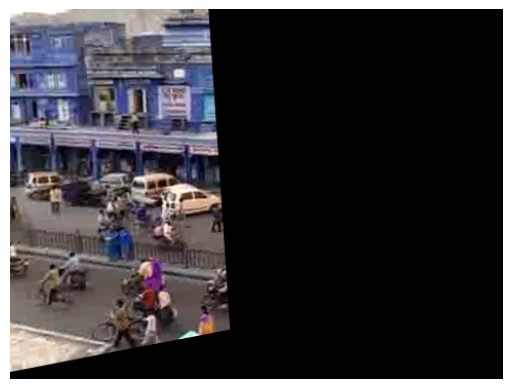

In [18]:
#get frame 200
frame_200 = warped_frames[199]
plt.imshow(frame_200)
plt.axis('off')  # to turn off axis numbers
plt.show()

### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


In [19]:
# TO DO part 4

### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [ ]:
# TO DO part 5



### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [ ]:
# TO DO part 6


## Bells and whistles